In [3]:
import torchvision
import torch
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import ceil
from time import time
import cv2

from sklearn.cluster import AgglomerativeClustering as AGC

import sys
sys.path.append("../")

from custom_functions.utils import get_n_percent_val, change_range, fit_curve
from custom_functions.Line import Line
from custom_functions.plotter import plot_features, plot_islands, draw_hv_lines, draw_curve_on_image
from custom_functions.cell_processing import extend_lines, \
                                             get_line_indices, \
                                             filter_out_small_lines, \
                                             get_clean_curves, \
                                             get_clean_lines

# Load and resize an image

In [4]:
# Data Path
image_root = Path("../images")
image_paths = list(image_root.glob("*"))

# VGG Part
device = "cpu"

resize = torchvision.transforms.Resize((2400, 3600))
# To change the size of resizing use` resize.size = (3600,2400)

vgg16_ = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.IMAGENET1K_V1).to(device=device)

# Load and resize an image

In [5]:
img = resize(torchvision.io.read_image(image_paths[-1].as_posix())).to(device=device, dtype=torch.float)

## Get The features from image with VGG16

In [6]:
feature_images = [img.clone()]

for i, feature in tqdm(enumerate(vgg16_.features[:2])):
    feature_images.append(feature(feature_images[-1]).detach())

2it [00:00,  2.45it/s]


# Dilating the lines (Important)

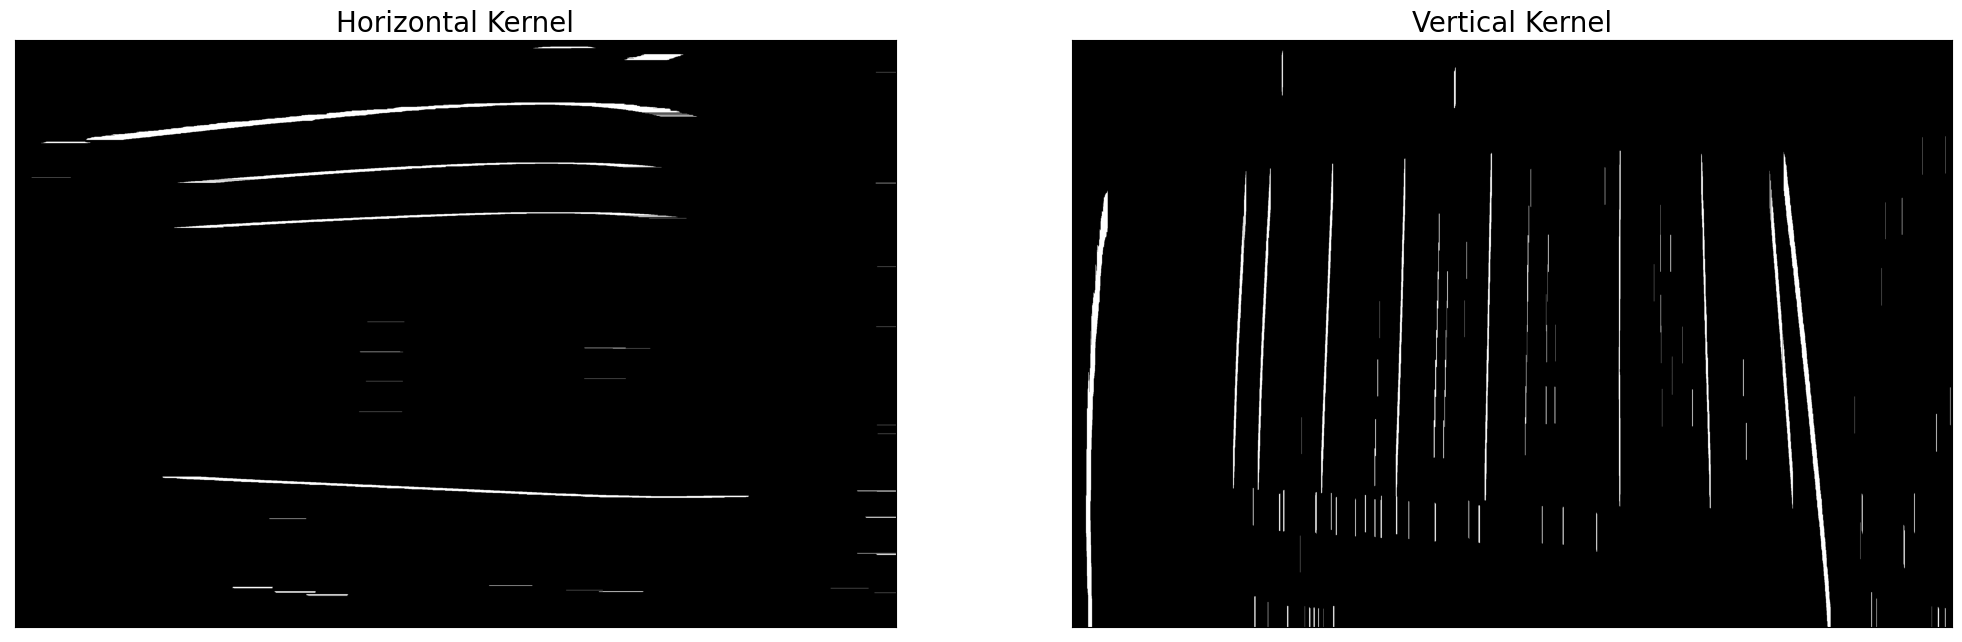

In [7]:
# Selecting Features for vertical and horizontal lines
vline = feature_images[1][17]
hline = feature_images[1][9]
v_b = vline>get_n_percent_val(vline, 0.95) ## Small threshold for small filtration
h_b = hline>get_n_percent_val(hline, 0.95) ## Small threshold for small filtration


img_bin_h = extend_lines(h_b, orientation="horizontal")
img_bin_v = extend_lines(v_b, orientation="vertical")

plt.figure(figsize=(25,25))


plt.subplot(121),plt.imshow(img_bin_h, cmap="gray")
plt.title('Horizontal Kernel', fontsize=20), plt.xticks([]), plt.yticks([])


plt.subplot(122),plt.imshow(img_bin_v, cmap="gray")
plt.title('Vertical Kernel', fontsize=20), plt.xticks([]), plt.yticks([])
plt.show()

# Filter out the small lines with Curves

In [25]:
angle1 = (np.arctan2((5,),(5,)))
angle2 = (np.arctan2((0,),(-5,)))
print(np.degrees(angle1))
print(np.degrees(angle2))

[45.]
[180.]


-1.2431446369467303 1.2431446369467303
-528 422


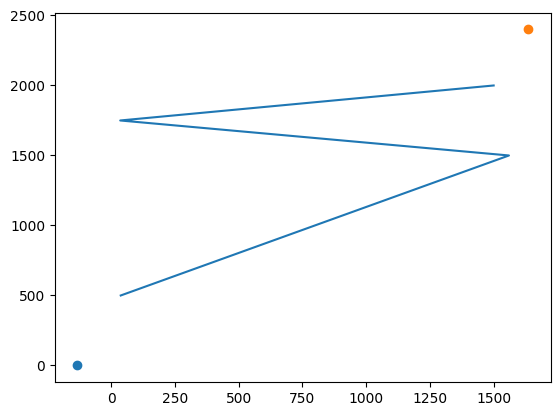

In [287]:
def point_distance(pt1, pt2):
    x1, y1 = pt1
    x2, y2 = pt2
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

def get_edge_point(x_coords, y_coords, left_most, right_most, vertical=False):
    '''
    Get the continuation of broken line  with its points
    -`x_coords`: x coordinates of the points line
    -`y_coords`: y coordinates of the points line
    - `leftmost`: the minimum allowed value for line start
    - `rightmost`: the maximum allowd value for line start
    - `vertical`: Determine wether the line is vertical or horizontal
    '''
    # The probable angle to the edge points for curve
##############################################################################
    force_angle_l =  -np.arctan2(np.diff(y_coords[:2]), np.diff(x_coords[:2]))[0]
    force_angle_r =  np.arctan2(np.diff(y_coords[-2:]), np.diff(x_coords[-2:]))[0]
    print(force_angle_l, force_angle_r)
    if vertical:
        distance_l = int(y_coords[0]/np.sin(force_angle_l))
        distance_r = int((right_most-y_coords[-1])/np.sin(force_angle_r))
        print(distance_l, distance_r)
        
        x_l = x_coords[0] + distance_l * np.cos(force_angle_l)
        x_r = x_coords[-1] + distance_r * np.cos(force_angle_r)
        
        y_l = left_most
        y_r = right_most
    else:
        distance_l = int(x_coords[0]/np.cos(force_angle_l))
        distance_r = int((right_most-x_coords[-1])/np.cos(force_angle_r))
        
        x_l = left_most
        x_r = right_most
        
        y_l = y_coords[0] + distance_l * np.sin(force_angle_l)
        y_r = y_coords[-1] + distance_r * np.sin(force_angle_r)
    
##############################################################################
    # Get the coordinates of edge point
    return ((x_l, y_l),(x_r, y_r)) # Return left edge point and Right edge point


xes = np.array([500,1500,1750,2000])
yes = np.array([38,1560,36,1500])

# print(get_edge_point(xes, yes, 0, 60, False))
plt.plot(yes, xes)
# plt.xlim(0,60)
# plt.ylim(0,60)
l, r = get_edge_point(yes, xes, 0, 2400, True)
plt.scatter(*l)
plt.scatter(*r)
# plt.scatter(*get_edge_point(yes, xes,0, 0, True))
# plt.scatter(*get_edge_point(yes, xes,0, 60, True))

plt.show()

In [288]:
def get_clean_curves(dilated_binary_image:np.ndarray, difference_threshold:float, vertical:bool, resolution=20):
    '''
    Get a cleaner image of the given dilated binary image. Clean small lines, get approximate points of curves for the remaining big lines on the image
    
    Returns:
        1. Cleaned image with only big lines on it
        2. Points of the curves passing through those lines
        3. A clean image containing only the curves on it
    '''
    num_groups, grouped = cv2.connectedComponents(dilated_binary_image, connectivity=8)
    group_areas = np.array([((grouped==i).sum()) for i in range(num_groups)])
    
    curve_step = 1/resolution
    
    lines = []
    
    clean_grouped, big_lines = filter_out_small_lines(dilated_binary_image, difference_threshold)
    img_with_curves = np.zeros_like(clean_grouped)
    
    # If vertical lines are needed, for correct curve extraction need to Transpose the image, draw the curves on it and then rotate back
    if vertical:
        img_with_curves = img_with_curves.T
    
    for i in big_lines:
        lines.append([])
        
        if i==0:
            continue
            
        group_indices = np.where(clean_grouped==i)
#         print(group_indices)
        x_list = []
        y_list = []
        # Get **[y]** coordinates if the vertical lines are required, **[x]** coordinates otherwise
        percentages = np.linspace(0,1,resolution)
        
        
        uniques = np.unique(group_indices[vertical])
        
        for j in range(resolution+1):
            y_list.append(int(get_n_percent_val(uniques, j*curve_step))) # Get coordinates of lines for constructing a curve
            x_list.append(int(np.mean(group_indices[not vertical][group_indices[vertical]==y_list[-1]])))
        
        # Appending starting and ending points to make the curves finished
#         y_list.append(y_list[0])
#         y_list.append(y_list[-2])

#         x_list.append(0)
#         x_list.append(dilated_binary_image.shape[not vertical])
    #############################################################################
#         Appending starting and ending points to make the curves finished
        start, end = get_edge_point(x_list, y_list, 0, dilated_binary_image.shape[not vertical], not vertical)
        y_list.append(start[1])
        y_list.append(end[1])

        x_list.append(start[0])
        x_list.append(end[0])
        
#         print(x_list, y_list)
        
    #############################################################################
        # Stack the x,y points on the curves
        points = np.stack((x_list, y_list))
        points = np.unique(points, axis=1)
        

        if points.shape[1] != (resolution+3):
            continue
        
        # Check if the distance between the start and the end of the curve is enough
        
        _line = Line(tuple(points[:,1]), tuple(points[:,-2]))
        if _line.length < 100:
            continue
            
        # Get the curve
        points = fit_curve(points)
        img_with_curves = (draw_curve_on_image(img_with_curves, points))
        lines[-1].append(points)
        
    if vertical:
        img_with_curves=img_with_curves.T
    
    return clean_grouped, lines, img_with_curves

-0.6274988218759788 0.6274988218759788
-0.7589595247806887 0.7589595247806887
-0.6268037111897242 0.6268037111897242
-1.2268276762354167 1.2268276762354167
-0.0 0.0
-2.3496415152369963 2.3496415152369963
-0.07661754657766204 0.07661754657766204
-0.0849892931926153 0.0849892931926153
-1.075901861713405 1.075901861713405
-3.0935186173077716 3.0935186173077716
-3.1132718481038593 3.1132718481038593
-0.033648218709107974 0.033648218709107974
-3.097485745060575 3.097485745060575
-2.9536797204327203 2.9536797204327203
-3.093373825203903 3.093373825203903
-0.1073650493967484 0.1073650493967484
-2.8070053035535727 2.8070053035535727


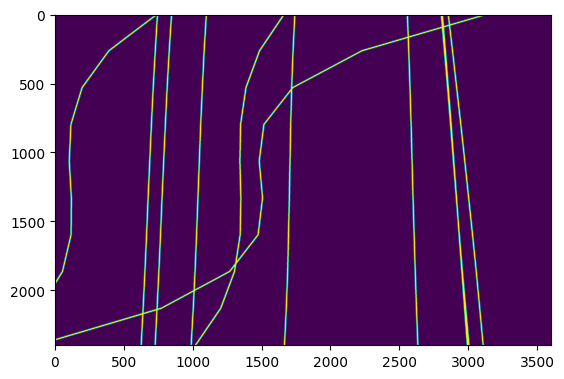

4027.44
__________________________________________________________
-3.083538649032168 3.083538649032168
-12185 48775
-2.921327535206083 2.921327535206083
-2306 13854
-0.049310508422207015 0.049310508422207015
-36234 35057
-2.9765757538471105 2.9765757538471105
-1576 19413


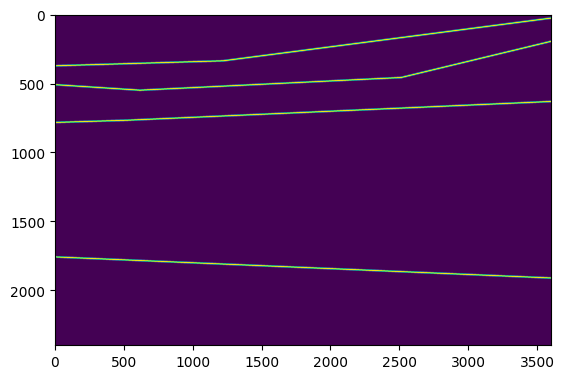

2019.84


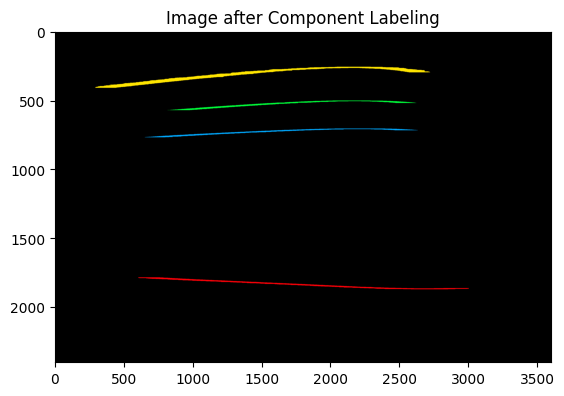

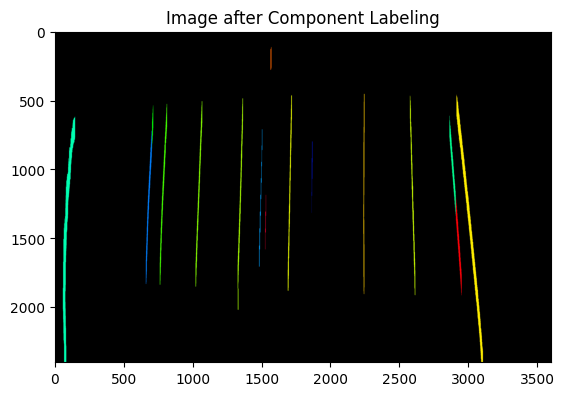

In [289]:
st = time()
filtered_img_bin_v, vlines, img_with_curves_v = get_clean_curves((img_bin_v>0).astype(np.uint8), 50, True)
plt.imshow(img_with_curves_v)
plt.show()
print(f"{(time()-st)*1000:.2f}")
# print(vlines)
print("__________________________________________________________")

st = time()
filtered_img_bin_h, hlines, img_with_curves_h = get_clean_curves((img_bin_h>0).astype(np.uint8), 3000, False)
plt.imshow(img_with_curves_h)
plt.show()
print(f"{(time()-st)*1000:.2f}")


plot_islands(filtered_img_bin_h, filtered_img_bin_v);

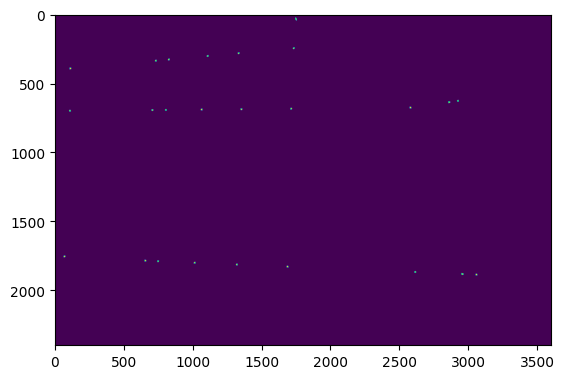

4258.00


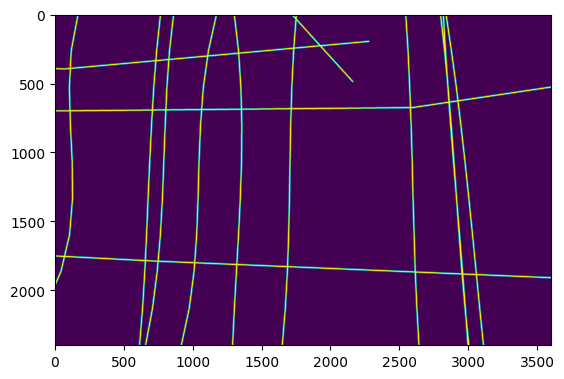

4746.50


In [284]:
intersected = img_with_curves_h&img_with_curves_v
plt.imshow(intersected)
plt.show()
print(f"{(time()-st)*1000:.2f}")


union = img_with_curves_h|img_with_curves_v
plt.imshow(union)
plt.show()
print(f"{(time()-st)*1000:.2f}")

# Clustering And point visualization

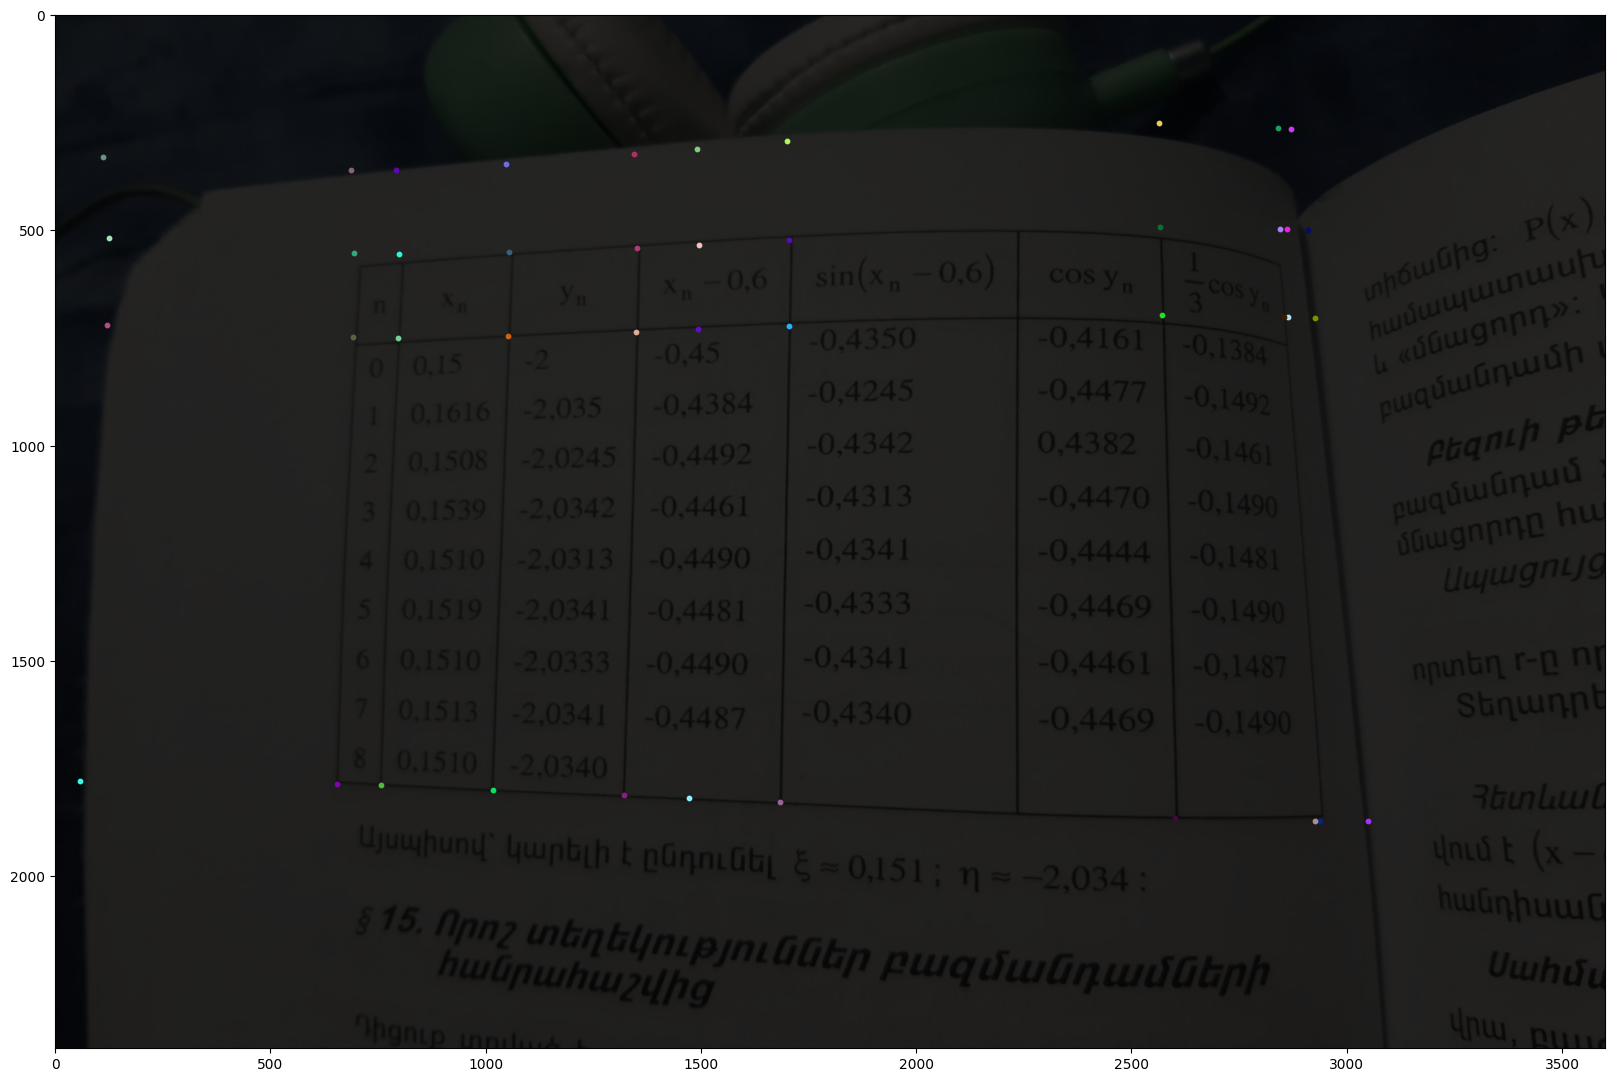

In [278]:
# scipy Agglomerative clustering class instance
AGC_ = AGC(n_clusters=None, distance_threshold=100)

#Finding the points
points = np.stack(np.where(intersected>0)).transpose(1,0)
clustered=(AGC_.fit_predict(points))

# Separating the unique clusters
uniques_ = np.unique(clustered)

# Centers for each unique cluster
box_points = []

plt.figure(figsize=(20,20))
plt.imshow((img.permute(1,2,0).numpy()*0.2).astype(np.uint8))
for unique_ in uniques_:
    area_points = points[ np.where(clustered==unique_)[0] ]
    box_points.append(np.mean(area_points,axis=0))
    plt.scatter(box_points[-1][1]-5,box_points[-1][0]-5,color=tuple(np.random.random(3)), marker="o", s=10 )
plt.show()
box_points = np.array(box_points, dtype=int)

# Subtracting text from `Vertical` lines (NO)

In [ ]:
vline = feature_images[1][17]
hline = feature_images[1][9]
text_ = feature_images[3][63]
no_text = feature_images[3][44]

v_b = vline>get_n_percent_val(vline, 0.95)
h_b = hline>get_n_percent_val(vline, 0.95)
fig, ax = plt.subplots(2,3,figsize=(30,20))
ax[0,0].imshow(v_b)
ax[0,1].imshow(h_b)
ax[0,2].imshow(no_text>get_n_percent_val(no_text, 0.5))
print(v_b.sum())
v_b[hline>0]=0
v_b[text_>0]=0
print(v_b.sum())

ax[1,0].imshow(v_b)
plt.tight_layout()
plt.show()
# plt.imshow(text_>50)

# Plotting All features (Visualisation)

In [137]:
a = [1,2,3,5]
a.append(a[-1])
a.append(a[-3])
a

[1, 2, 3, 5, 5, 3]

In [24]:
feature_images = [img.clone()]

for i, feature in tqdm(enumerate(vgg16_.features[:9])):
    feature_images.append(feature(feature_images[-1]).detach())

9it [00:17,  1.93s/it]


In [ ]:
feature_list = img.clone()

for i, feature in tqdm(enumerate(vgg16_.features[0:2])):
    feature_list = feature(feature_list)
    plot_features(feature_list.to(torch.uint8).cpu(), feature, i)


# Harris Corner Finding (NO)

In [ ]:
img__ = feature_images[1][20].clone()
img__[img__>0]=255
img__ = img__.numpy().astype(np.float32)
img__.dtype

<IPython.core.display.Javascript object>


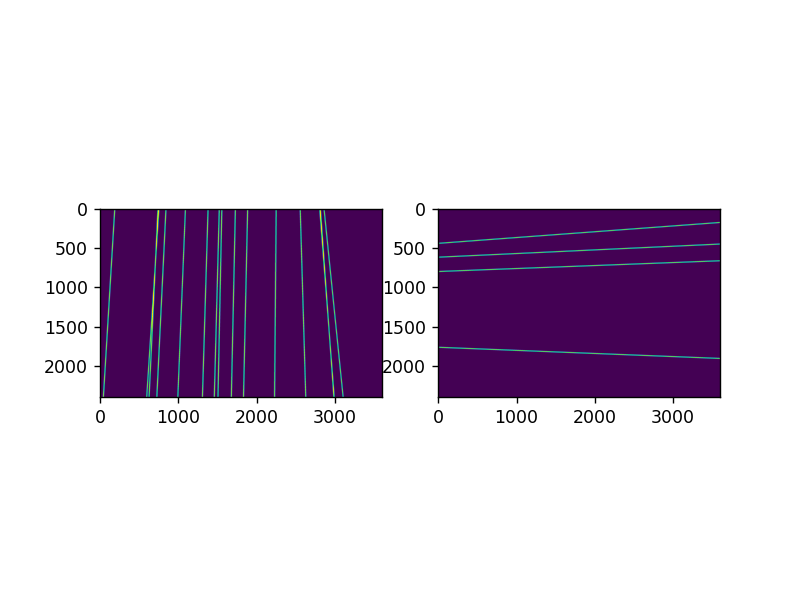

In [167]:
%matplotlib notebook
fig,ax = plt.subplots(ncols=2)
ax[0].imshow(img_v)
ax[1].imshow(img_h)
plt.show()

<IPython.core.display.Javascript object>


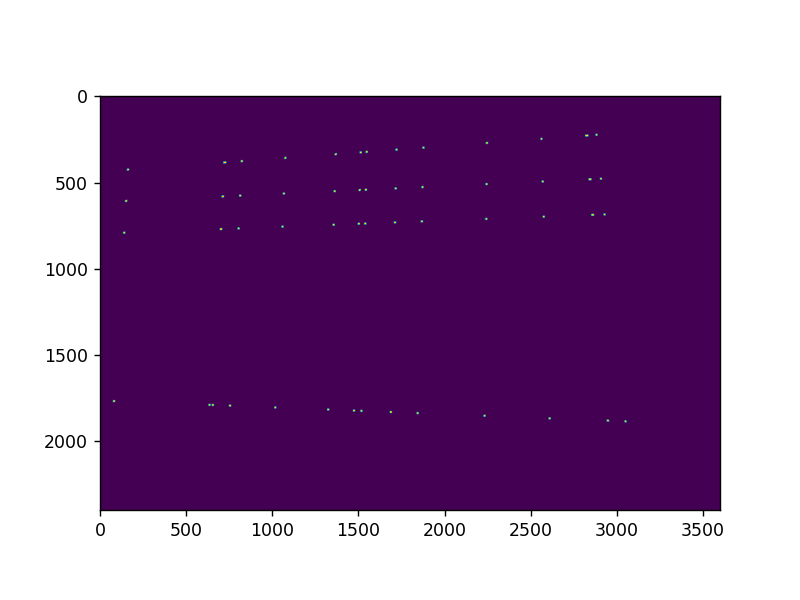

In [171]:
# intersected = (img_bin_v&img_bin_h)
intersected = (img_v&img_h)

# plt.figure(figsize=(25,25))
plt.imshow(intersected)

In [ ]:
dst = cv2.cornerHarris(cv2.cvtColor(img.permute(1,2,0).numpy(), cv2.COLOR_RGB2GRAY).astype(np.float32),5,21,0.0001)
# #result is dilated for marking the corners, not important
dst = cv2.dilate(dst,None)
plt.figure(figsize=(20,20))
plt.imshow(dst)
plt.show()

# # Threshold for an optimal value, it may vary depending on the image.
# img[dst>0.01*dst.max()]=[0,0,255]
# plt.imshow(img)